In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')



In [2]:
stock_data = pd.read_csv("Google_StockTrain.csv")
test_data = pd.read_csv("Google_StockTest.csv")

In [3]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values(by=['Date'], ascending=True).reset_index()

In [4]:
input_feature = stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
input_data[:,:] = scaler.fit_transform(input_data[:,:])

In [6]:
lookback=120
total_size=len(stock_data)
X=[]
y=[]
for i in range(0, total_size-lookback): 
    t=[]
    for j in range(0, lookback):
        current_index = i+j
        t.append(input_data[current_index, :])
    X.append(t)
    y.append(input_data[lookback+i, 4])

In [7]:
test_size=200 
X, y= np.array(X), np.array(y)
X_test = X[:test_size]
Y_test = y[:test_size]

X_work = X[test_size:]
y_work = y[test_size:]

validate_size = 20

X_valid = X[:validate_size]
y_valid = y[:validate_size]
X_train = X[validate_size:]
y_train = y[validate_size:]

In [8]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1118, 120, 5)
(20, 120, 5)
(200, 120, 5)


In [9]:
from keras import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences= True, activation='relu', input_shape=(X.shape[1], 5)))
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(LSTM(50))
model.add(Dense(1))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120, 50)           11200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [12]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=callbacks)

Train on 1118 samples, validate on 20 samples
Epoch 1/100
1118/1118 [==============================] - 8s 7ms/step - loss: 0.0375 - accuracy: 8.9445e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00402, saving model to model.h5
Epoch 2/100
1118/1118 [==============================] - 6s 5ms/step - loss: 0.0018 - accuracy: 8.9445e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.00402 to 0.00189, saving model to model.h5
Epoch 3/100
1118/1118 [==============================] - 6s 5ms/step - loss: 0.0015 - accuracy: 8.9445e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 0.00189 to 0.00188, saving model to model.h5
Epoch 4/100
1118/1118 [==============================] - 5s 5ms/step - loss: 0.0015 - accuracy: 8.9445e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.00188
Epoch 5/100
1118/1118 [=========================

In [13]:
predicted_value = model.predict(X_test)

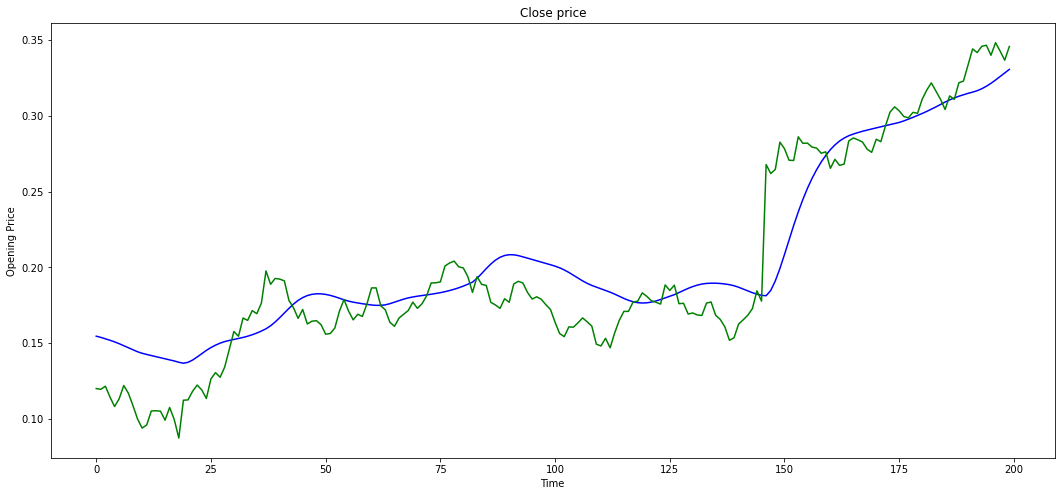

In [14]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'blue')
plt.plot(Y_test, color='green')
plt.title("Close price")
plt.xlabel("Time")
plt.ylabel("Opening Price")
plt.show()